In [1]:
# import relevant libraries
import numpy as np
import glob
import os
import pathlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from impactClass import impactClass
from impactClass import impactClassList
%matplotlib inline


In [2]:
# define method to load population data from files
def loadPopData(filename):
    dat = np.loadtxt(filename)
    lat = dat[[np.arange(0,90,1),1]]
    lon = dat[[np.arange(0,np.shape(dat)[0],90),0]]
    P = np.zeros((9,np.shape(lon)[0],np.shape(lat)[0]))
    Px = [1e-7,5e-7,1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3]
    for ii in range(0,9):
          P[ii] = np.reshape(dat[...,ii+2],[np.shape(lon)[0],np.shape(lat)[0]])
    out = {'lat' : lat, 'lon' : lon, 'P' : P, 'Px' : Px}
    return out

In [3]:
# load impact data
p = pathlib.PurePath(os.getcwd())
BASE_DIR = str(p.parent)
dataDir = '/data'
impFiles = glob.glob(BASE_DIR + dataDir + '/ONLY_IMPACTS/*_grs1.pickle')
imps = []
for idx,impFile in enumerate(impFiles):
    imp = impactClass(impFile, dataDir = dataDir, BASE_DIR = BASE_DIR)
    imp.SCtoSun()
    imp.findSkyAngles()
    imps.append(imp)

In [4]:
cl = 68
ll = (100-68)/2.0
ul = 100-ll
P = np.zeros((len(imps),3))
A = np.zeros((len(imps),1))
lat = np.zeros_like(P)
lon = np.zeros_like(P)
for idx,imp in enumerate(imps):
    A[idx] = imp.skyArea
    P[idx,...] = np.percentile(imp.Ptot,[50,ll,ul])
    lat[idx,...] = np.percentile(imp.lat_sun,[50,ll,ul])
    lon[idx,...] = np.percentile(imp.lon_sun,[50,ll,ul])

In [76]:
APfit = np.polyfit(np.log10(P[...,0]),np.log10(A),1)
print(APfit)

[[-0.72450884]
 [ 4.15757438]]


In [5]:
thresh = 0.1*41253
Agood = A[np.where(A < thresh)]
Pgood = P[(np.where(A < thresh),...)]
latGood = lat[(np.where(A < thresh),...)]
lonGood = lon[(np.where(A < thresh),...)]


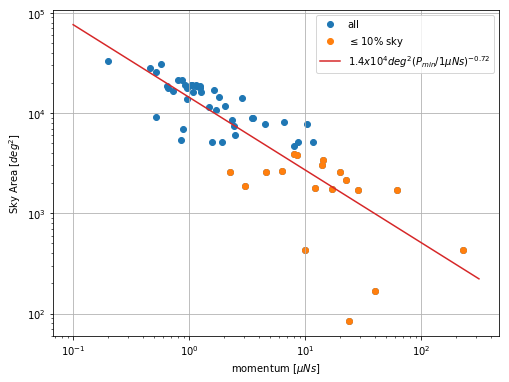

In [84]:
fig = plt.figure(figsize = [8, 6])
ax = plt.subplot(111)
plt.scatter(P[...,0],A,label='all')
plt.scatter(Pgood[0,...,0],Agood,label='$\leq$10% sky')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
xplot = np.logspace(-1,2.5,100)
lineLab = '$%2.1f x 10^4 deg^2(P_{min}/1\mu N s)^{%2.2f}$' % (10**(APfit[1])/1e4, APfit[0])
plt.plot(xplot,(10**APfit[1])*xplot**(APfit[0]),color='tab:red',label=lineLab)
plt.xlabel('momentum $[\mu Ns]$')
plt.ylabel('Sky Area $[deg^2]$')
handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]
ax.legend(handles,labels,loc=1)


In [ ]:
# Sky area plot to look for anamolous retrograde impacts
x = lonGood[0,...,0]
dx = [lonGood[0,...,0]-lonGood[0,...,1],lonGood[0,...,2]-lonGood[0,...,1]]
y = latGood[0,...,0]
dy = [latGood[0,...,0]-latGood[0,...,1],latGood[0,...,2]-latGood[0,...,1]]

idxR = np.where((x > 45) & (x < 135))

fig = plt.figure(figsize = [8, 6])
plt.errorbar(x,y,yerr=dy,xerr=dx,linestyle='none',marker='o')
plt.errorbar(x[idxR],y[idxR],yerr=[dy[0][idxR],dy[1][idxR]],xerr=[dx[0][idxR],dx[1][idxR]],linestyle='none',marker='o')
plt.text(0,0,'$\odot$',fontsize=18,horizontalalignment='center',verticalalignment='center')
plt.text(-90,0,'$P$',fontsize=18,horizontalalignment='center',verticalalignment='center')
plt.text(90,0,'$R$',fontsize=18,horizontalalignment='center',verticalalignment='center')
plt.grid(True)
plt.xlabel('lon [deg]')
plt.ylabel('lat [deg]')


In [65]:
# read all population files
popNames = ['JFC','HTC','OCC','AST']
# make plot directory
baseDir = '../data/models'
plotDir = '../plots'
pops = dict()
for ii in range(0,len(popNames)):
    pops[ii] = loadPopData(BASE_DIR + '/data/models/' + popNames[ii] + '_impulse.dat')
    



In [71]:
hlat = np.zeros([len(pops),len(pops[0]['lat'])])
hlon = np.zeros([len(pops),len(pops[0]['lon'])])
for ii in range(0,len(pops)):
    # read in momentum sky bins
    plon = pops[ii]['lon']*np.pi/180
    plat = pops[ii]['lat']*np.pi/180
    Psky = np.transpose(pops[ii]['P'][2])
    dlat = plat[1]-plat[0]
    dlon = plon[1]-plon[0]
    Fsky = np.zeros(np.shape(Psky))
    for jj in range(0,len(plon)):
        hlon[ii,jj] = np.sum(Psky[...,jj]/(np.cos(plat)*dlon))
    
    for jj in range(0,len(plat)):
        hlat[ii,jj] = np.sum(Psky[jj,...])/dlat
    
    #hlat[ii,...] = np.sum(Fsky,axis=1)
    #hlon[ii,...] = np.sum(Fsky,axis=0)

In [61]:
np.shape(Psky)

(90, 180)

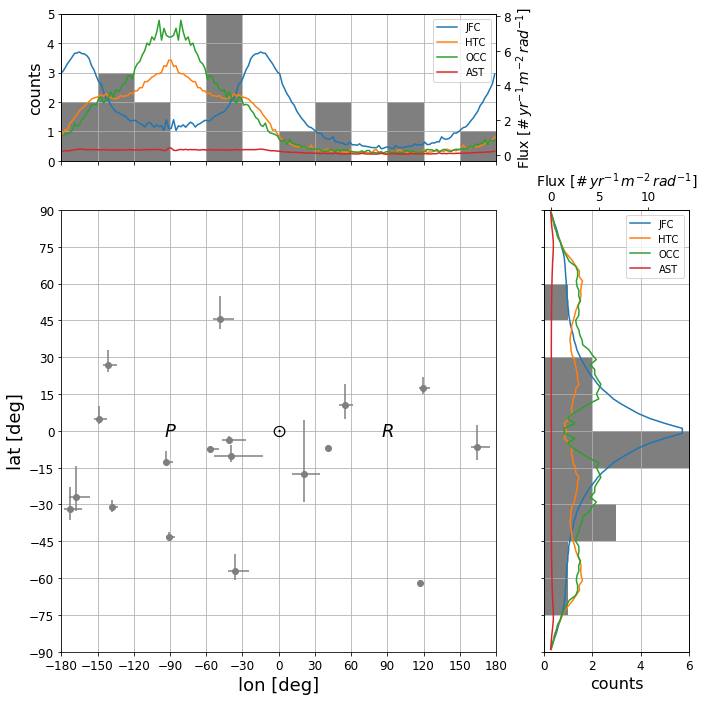

In [72]:
# do histograms
latBins = np.arange(-90,91,15)
lonBins = np.arange(-180,181,30)
latHist = np.histogram(latGood[0,...,0],latBins)
lonHist = np.histogram(lonGood[0,...,0],lonBins)
# set up figure
fig = plt.figure(figsize = [10, 10])
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1,3]) 
# longitude histogram
axlon = plt.subplot(gs[0])
axlon.hist(lonGood[0,...,0],lonBins,orientation='vertical',color='tab:gray')
axlon.grid(True)
plt.ylim([0,5])
plt.xlim([-180,180])
plt.xticks(lonBins)
plt.ylabel('counts',fontsize=16)
axlon.set_xticklabels([])
axlon.tick_params(labelsize=12)
# longitude population flux density
axlon2 = axlon.twinx()
for ii in range(0,len(pops)):
    plt.plot(pops[ii]['lon'],hlon[ii,...]*3.154e7)

plt.ylabel('Flux $[\#\,yr^{-1}\,m^{-2}\,rad^{-1}]$',fontsize=14)
plt.legend(popNames)
axlon2.tick_params(labelsize=12)
# lat/lon map
axmap = plt.subplot(gs[2])
x = lonGood[0,...,0]
dx = [lonGood[0,...,0]-lonGood[0,...,1],lonGood[0,...,2]-lonGood[0,...,1]]
y = latGood[0,...,0]
dy = [latGood[0,...,0]-latGood[0,...,1],latGood[0,...,2]-latGood[0,...,1]]
axmap.errorbar(x,y,yerr=dy,xerr=dx,linestyle='none',marker='o',color='tab:gray')
axmap.text(0,0,'$\odot$',fontsize=18,horizontalalignment='center',verticalalignment='center')
axmap.text(-90,0,'$P$',fontsize=18,horizontalalignment='center',verticalalignment='center')
axmap.text(90,0,'$R$',fontsize=18,horizontalalignment='center',verticalalignment='center')
axmap.grid(True)
plt.xlim([-180,180])
plt.xticks(lonBins)
plt.ylim([-90,90])
plt.yticks(latBins)
plt.xlabel('lon [deg]',fontsize=18)
plt.ylabel('lat [deg]',fontsize=18)
axmap.tick_params(labelsize=12)
# latitude histogram
axlat = plt.subplot(gs[3])
axlat.hist(latGood[0,...,0],latBins,orientation='horizontal',color='tab:gray')
axlat.grid(True)
plt.ylim([-90,90])
plt.yticks(latBins)
plt.xlim([0,6])
plt.xlabel('counts',fontsize=16)
axlat.set_yticklabels([])
axlat.tick_params(labelsize=12)
# latitude flux density
axlat2 = axlat.twiny()
for ii in range(0,len(pops)):
    plt.plot(hlat[ii,...]*3.154e7,pops[ii]['lat'])

plt.xlabel('Flux $[\#\,yr^{-1}\,m^{-2}\,rad^{-1}]$',fontsize=14)
plt.legend(popNames)
axlat2.tick_params(labelsize=12)
fig.tight_layout()
fig.savefig(plotDir + '/mapCompare.eps', format = 'eps')

In [ ]:
a

In [ ]:
# polar plot
r = np.log10(Pgood[0,...,0])
theta = lonGood[0,...,0]
idxR = np.where((theta > 45) & (theta < 135))
fig = plt.figure(figsize = [12, 12])
ax = fig.add_subplot(111, projection='polar')
ax.scatter(theta*np.pi/180,r)
ax.scatter(theta[idxR]*np.pi/180,r[idxR])